### Imports

In [1]:
# Import all of the requried libraries
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
import pandas as pd
# import statistics
from statistics import mode,mean
from scipy import interpolate
import os
import json
import time

# These are all of the libraries that I manually created

import IOfunctions as IO
import GUIfunctions as GUI
import Processfunctions as process

# Through 3D slicer
# start_index = 0 # starts at 195nm
# start_index = 742 # starts at 350nm
start_index = 790 # starts at 360nm
# start_index = 1070 # starts at 420nm



## Data Loading and Formatting 


#### Load, Format, and Save data

In [2]:
# This function combines loading the data with 
def loadDataset(dataPath,start_index=790,end_index=-1,sep=','):
    Dataset = []
    print("Loading in: ", dataPath)
    for name in os.listdir(dataPath):
#         print(name)
        df = pd.read_csv(os.path.join(dataPath,name), sep=sep,engine='python', header=None)
        # trim to 360 nm
        df = df.iloc[:, start_index:]
        # convert to an array
        data_arr = df.to_numpy()
        # Sum the columns of the array
#         spectrum_arr = np.sum(data_arr[1:, 1:],axis=0)
        spectrum_arr = np.mean(data_arr[1:, 1:],axis=0)
        # Grab the wavelength values
        wavelength_arr = data_arr[0, 1:]
        # Concatenate the vectors as columns
        data_arr = np.concatenate((wavelength_arr.reshape(-1,1), spectrum_arr.reshape(-1,1)), axis=1)
        # append to the dataset
        Dataset.append(data_arr)
    Dataset = np.array(Dataset,dtype='float')
    return Dataset

# LOADING DATASET 
FORMAT_DATASET = True
dataset_name = 'KidneyData_march3'
trialPath = "C:/Users/David/OneDrive - Queen's University/1 Graduate Studies/1 Thesis Research/KidneyData_march3/March3_KidneyCollectionWithDrRen/Mar03"
sampleNameList = [f for f in os.listdir(trialPath) if f.startswith('Patient')]

# define a pandas df to store the incoming data
class0_name = 'Normal'
class1_name = 'Cancer'

if FORMAT_DATASET:
    Formatted_dataset_df = pd.DataFrame(columns=['PatientID', 'SampleID', 'Label (numeric)', 'Label', 'Data'])  
    for sampleName in sampleNameList:
        patientID = sampleName.split('_')[0]
        sampleID = sampleName.split('_')[1] + '_' +sampleName.split('_')[2]
        # define the class names for folders which start with cancer or normal
        classNameList = [f for f in os.listdir(os.path.join(trialPath,sampleName)) if f.startswith('Cancer') or f.startswith('Normal')]
        # Remove names containing AmbientLight
        classNameList = [f for f in classNameList if not f.endswith('AmbientLight')]
        # for each folder sampleName folder, check if the class folders exist
        for className in classNameList:
            # if className contains cancer, then label = 1
            if class0_name in className:
                label = 0
            else:
                label = 1
            # Check to see if the path exists
            dataPath = os.path.join(trialPath,sampleName,className)
            if os.path.exists(dataPath):
                # sampleNameDict[sampleName+'_'+className] = 1 #loadDataset(dataPath,start_index=start_index, sep=',')
                data = loadDataset(dataPath,start_index=start_index, sep=',')
                # for each data file, append to the dataset
                for i in range(data.shape[0]):
                    new_row = {'PatientID':patientID, 
                            'SampleID':sampleID, 
                            'Label (numeric)':label, 
                            'Label':className, 
                            'Data':data[i,:,:]
                    }
                    # Dataset_df = Dataset_df.append(new_row, ignore_index=True)
                    Formatted_dataset_df = pd.concat([Formatted_dataset_df, pd.DataFrame([new_row])], ignore_index=True)
    # For each Data, convert the array to a string and save it to a csv file
    Formatted_dataset_df['Data'] = Formatted_dataset_df['Data'].apply(lambda x: json.dumps(x.tolist()))
    file_name = os.path.join(trialPath, dataset_name + '_Formatted_Dataset.csv')
    Formatted_dataset_df.to_csv(file_name, index=False)

Loading in:  C:/Users/David/OneDrive - Queen's University/1 Graduate Studies/1 Thesis Research/KidneyData_march3/March3_KidneyCollectionWithDrRen/Mar03\PatientA_Sample1_back\Cancer
Loading in:  C:/Users/David/OneDrive - Queen's University/1 Graduate Studies/1 Thesis Research/KidneyData_march3/March3_KidneyCollectionWithDrRen/Mar03\PatientA_Sample1_back\Normal
Loading in:  C:/Users/David/OneDrive - Queen's University/1 Graduate Studies/1 Thesis Research/KidneyData_march3/March3_KidneyCollectionWithDrRen/Mar03\PatientA_Sample1_front\Cancer
Loading in:  C:/Users/David/OneDrive - Queen's University/1 Graduate Studies/1 Thesis Research/KidneyData_march3/March3_KidneyCollectionWithDrRen/Mar03\PatientA_Sample1_front\Normal
Loading in:  C:/Users/David/OneDrive - Queen's University/1 Graduate Studies/1 Thesis Research/KidneyData_march3/March3_KidneyCollectionWithDrRen/Mar03\PatientA_Sample2_back\Cancer
Loading in:  C:/Users/David/OneDrive - Queen's University/1 Graduate Studies/1 Thesis Researc

### Load from file

In [3]:
# Load in the dataset
Dataset_df = pd.read_csv(file_name)
# For each Data, convert the string back to an array
Dataset_df['Data'] = Dataset_df['Data'].apply(lambda x: np.array(json.loads(x)))
Dataset_df.shape

(399, 5)

## Visualization Trials

### Split data

In [4]:
# Now that I have everything compiled into a dataframe, I can now split the data

# Split the whole dataste into data into two classes
allNormal_df = Dataset_df[Dataset_df['Label (numeric)'] == 0]
allCancer_df = Dataset_df[Dataset_df['Label (numeric)'] == 1]

# Get just data which sampleID contains 1_front
sample1Normal_df = allNormal_df[allNormal_df['SampleID'].str.contains('1')]
sample1Cancer_df = allCancer_df[allCancer_df['SampleID'].str.contains('1')]

data_0_df = allNormal_df
data_1_df = allCancer_df

# Extract the data from the dataframe
data_0 = np.array(data_0_df['Data'].tolist())
labels0 = np.array(data_0_df['Label (numeric)'].tolist())
data_1 = np.array(data_1_df['Data'].tolist())
labels1 = np.array(data_1_df['Label (numeric)'].tolist())

# labels1 = data_1_df['Label']



In [5]:
print('Normal data shape: ',data_0.shape)
print('Cancer data shape: ',data_1.shape)
# print the labels shape
print('Normal labels: ',labels0.shape)
print('Cancer labels: ',labels1.shape)


Normal data shape:  (84, 2858, 2)
Cancer data shape:  (315, 2858, 2)
Normal labels:  (84,)
Cancer labels:  (315,)


#### Load in the broadband transfer function

In [6]:
def loadSpectrum(path, col_name=None,start_index=774,end_index=-1,sep=';'):
#     df = pd.read_csv(path + name,sep=';',engine='python')
    df = pd.read_csv(path,sep=sep,engine='python')
#     print(df)
    if not(col_name == None):
        df[col_name] = df.index
    data = df[start_index:end_index]
#     print(data)
    data_arr = data.to_numpy()
    data_arr = np.array(data_arr,dtype='float')
    return data_arr

# LOAD IN BASELINES

dataPath = os.getcwd()
folderName = 'March2022_raw_data'
file_name = 'SLS201L_Spectrum_reformatted.csv'
dataPath_BrOut = os.path.join(dataPath,"data",folderName,file_name)
print(dataPath_BrOut)
baseline_BrOut_raw = loadSpectrum(dataPath_BrOut, 'Wavelength', start_index=10, end_index=675, sep=',')
# Interpolate such that the downloaded spectrum has the same values of the data
x = baseline_BrOut_raw[:,0]
y = baseline_BrOut_raw[:,1]
f = interpolate.interp1d(x,y)
xnew = data_0[0,:,0]
ynew = f(xnew)
baseline_BrOut = np.transpose(np.array([xnew,ynew]))
print(baseline_BrOut.shape)
print('Data shape', data_0.shape)

c:\Spectroscopy_TrackedTissueSensing\data\March2022_raw_data\SLS201L_Spectrum_reformatted.csv
(2858, 2)
Data shape (84, 2858, 2)


In [7]:
# plt.plot(data_0[0,:,0],data_0[0,:,1])
# plt.plot(data_1[0,:,0],data_1[0,:,1])
# data_0.shape
# print(data_0[0,0,0])

### Display the raw data

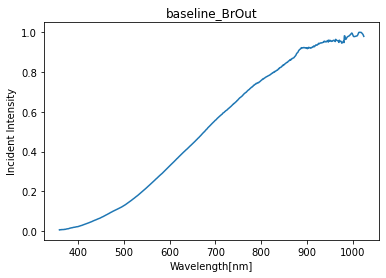

In [8]:
# Displaying all of the spectra to visually inspect results

# This should be in GUI with all the inputs as parameters
wavelength_start = data_0[0,0,0]
wavelength_end = data_0[0,-1,0]

w = np.linspace(wavelength_start,wavelength_end,len(data_0[1]))
# # # Display an example of data_0
# GUI.plotSpectra(xdata=data_0[0,:,0],ydata=data_0[0,:,1],xlab='Wavelength(nm)',ylab='Reflected Intensity',
#                 title='Unprocessed data_0 Spectrum')
# # Display an example of data_1
# GUI.plotSpectra(xdata=data_1[0,:,0], ydata=data_1[0,:,1],xlab='Wavelength(nm)',ylab='Reflected Intensity',
#                 title='Unprocessed data_1 Spectrum' )
# Display an example of broadband output
GUI.plotSpectra(xdata=baseline_BrOut[:,0],ydata=baseline_BrOut[:,1],xlab="Wavelength[nm]",
            ylab='Incident Intensity',title='baseline_BrOut')

In [9]:
# Function to plot all the spectra
def plotAll(data,title='', xtitle='', ytitle=''):
    plt.figure()
    for i in range(len(data)):
        plt.plot(data[i,:,0],data[i,:,1])
    plt.title(title)
    plt.xlabel(xtitle)
    plt.ylabel(ytitle)


def plotWColourMap(data, title, xlabel, ylabel, step=1):
    """
    Plot all samples of class1 on a single figure using a colour map to denote chronological order.

    Args:
    - data (ndarray): a 3D array of shape (num_samples, num_wavelengths, 2) containing the spectral data
    - title (str): the title of the plot
    - xlabel (str): the label of the x-axis
    - ylabel (str): the label of the y-axis

    Returns:
    - None
    """

    # create the colour map
    cmap = plt.get_cmap('viridis')

    # plot the data with the colour map
    plt.figure()
    for i in range(len(data)-1):
        # plot every third spectra
        if i%step == 0:
            plt.scatter(data[i,:,0], data[i,:,1], s=0.1, c=cmap(i/len(data)))

    # add a color bar
    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm.set_array([])
    plt.colorbar(sm)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)


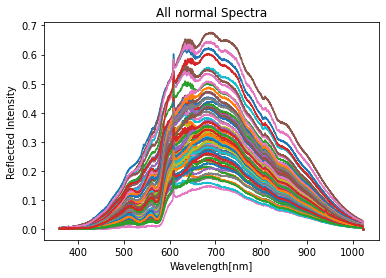

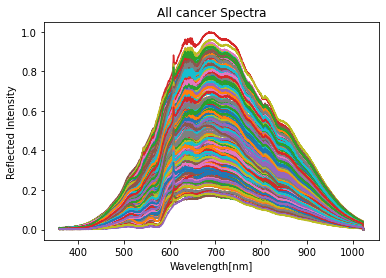

In [10]:
# Plot all samples of class0 on a single figure without using plotSpectra
plotAll(data_0,'All normal Spectra','Wavelength[nm]','Reflected Intensity')

# Plot all samples of class1 on a single figure without using plotSpectra
plotAll(data_1,'All cancer Spectra','Wavelength[nm]','Reflected Intensity')

# GUI.plotSpectra(xdata=data_1[0,:,0], ydata=data_1[0,:,1],xlab='Wavelength(nm)',ylab='Reflected Intensity',
#                 title='Unprocessed data_1 Spectrum' )


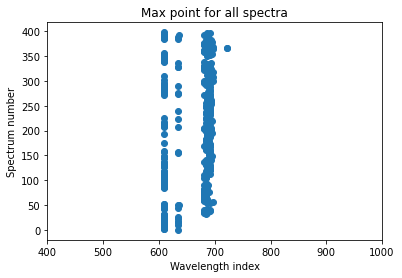

In [11]:
# PLOT the location of the max point for each spectrum
def plotMax(data, title, xlabel, ylabel):
    """
    Plot the location of the max point for each spectrum.

    Args:
    - data (ndarray): a 3D array of shape (num_samples, num_wavelengths, 2) containing the spectral data
    - title (str): the title of the plot
    - xlabel (str): the label of the x-axis
    - ylabel (str): the label of the y-axis

    Returns:
    - None
    """

    # find the max point for each spectrum
    max_points_indices = np.argmax(data[:,:,1], axis=1)
    # Find the corresponding wavelength
    max_points = data[:,max_points_indices,0]
    # plot the max points
    SampleNumber = range(len(data))
    plt.figure()
    plt.scatter(max_points[0],range(len(data)))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    # change the range of the x-axis
    plt.xlim(400, 1000)

# concatinate the data_0 and data_1
d = np.concatenate((data_0, data_1), axis=0)
# Plot the location of the max point for each spectrum of class0
plotMax(d, 'Max point for all spectra', 'Wavelength index', 'Spectrum number')


In [12]:
# data_0_save = data_0.copy()
# data_1_save = data_1.copy()

# data_0 = data_0_save.copy()
# data_1 = data_1_save.copy()


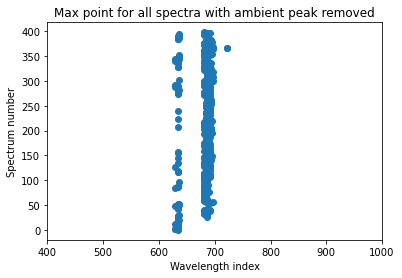

In [13]:
# temporayily remove the peak caused by ambient light
data_0_new = data_0.copy()
data_1_new = data_1.copy()
# Set the spectra to zero between 600 and 650 nm
# This is to remove the background noise using no functions
def removeAmbientLight(data):
    start_index = 1110
    width = 20
    end_index = start_index + width
    for i in range(len(data)):
        data[i,start_index:end_index,1] = 0
    return data

data_0_new = removeAmbientLight(data_0_new)
data_1_new = removeAmbientLight(data_1_new)

# concatinate the data_0 and data_1
d = np.concatenate((data_0_new, data_1_new), axis=0)
# Plot the location of the max point for each spectrum of class0
plotMax(d, 'Max point for all spectra with ambient peak removed', 'Wavelength index', 'Spectrum number')

### Preprocessing of the data
* Normalize so peak is 1
* Crop to 360nm to 1024nm
* Divide by the broadband output

Text(0, 0.5, 'Reflected Intensity')

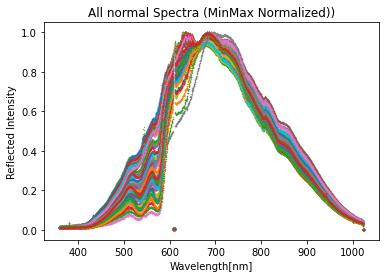

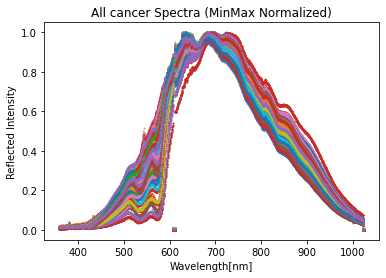

In [14]:
# Normalize the data
data_0_norm = data_0_new.copy()
data_1_norm = data_1_new.copy()
data_0_norm = process.normalize(data_0_norm)
data_1_norm = process.normalize(data_1_norm)

# Plot them again
# Plot all samples of class0 on a single figure without using plotSpectra
plt.figure()
for i in range(len(data_0_norm)):
    plt.scatter(data_0_norm[i,:,0] ,data_0_norm[i,:,1],s=0.1)
plt.title('All normal Spectra (MinMax Normalized))')
plt.xlabel('Wavelength[nm]')
plt.ylabel('Reflected Intensity')

# Plot all samples of class1 on a single figure without using plotSpectra
plt.figure()
for i in range(len(data_1_norm)):
    plt.scatter(data_1_norm[i,:,0],data_1_norm[i,:,1],s=0.5)
plt.title('All cancer Spectra (MinMax Normalized)')
plt.xlabel('Wavelength[nm]')
plt.ylabel('Reflected Intensity')

# # plot one cancer and one normal spectrum on a scatter plot
# plt.figure()
# plt.scatter(data_0_norm[0,:,0],data_0_norm[0,:,1],s=0.5)
# plt.scatter(data_1_norm[0,:,0],data_1_norm[0,:,1],s=0.5)
# plt.title('One cancer and one normal spectrum [MinMax Normalized]')
# plt.xlabel('Wavelength[nm]')
# plt.ylabel('Reflected Intensity')
# plt.legend(['Normal','Cancer'])

In [15]:
# # Plot each spectra using a color map to show how the spectra change over time
# # This is to see if there is any pattern in the spectra
# # use scatter plot to show the data points

# # create the colour map
# cmap = plt.get_cmap('viridis')

# # plot the data with the colour map
# plt.figure()
# for i in range(len(data_1_norm)-1):
#     plt.scatter(data_1_norm[i,:,0],data_1_norm[i,:,1],s=0.1,c=cmap(i/len(data_1_norm)))

# # add a color bar
# sm = plt.cm.ScalarMappable(cmap=cmap)
# sm.set_array([])
# plt.colorbar(sm)

# plt.title('All normal Spectra (MinMax Normalized)')
# plt.xlabel('Wavelength[nm]')
# plt.ylabel('Reflected Intensity')




*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

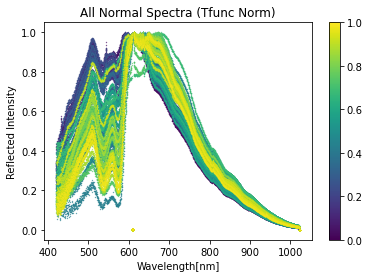

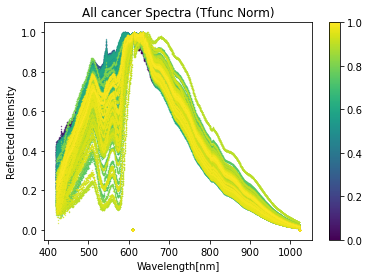

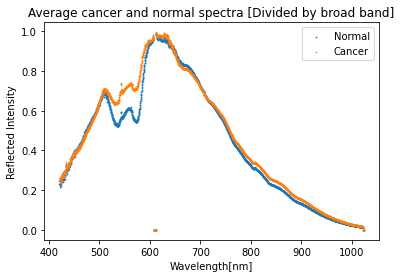

In [16]:
FLAG_Baseline = True
# Load in the baseline 
baseline = baseline_BrOut # --------------------------------- flag
baseline = process.normalize(baseline)[:,1]

data_0_norm = data_0_new[:,280:,:].copy()
data_1_norm = data_1_new[:,280:,:].copy()
baseline = baseline[280:].copy()
tFunc = baseline

def divTfuc(inputData,tFunc, flag):    
    outputData = inputData.copy()
    if FLAG_Baseline:
        # For each spectra
        for i in range (inputData[:,:,1].shape[0]):
            data = inputData[i,:,1]
            # Divide by the baseline transfer function
            outputData[i,:,1] = data / tFunc 
    outputData = process.normalize(outputData)
    return outputData
# call the function
data_0_norm_T = divTfuc(data_0_norm,tFunc, FLAG_Baseline)
data_1_norm_T = divTfuc(data_1_norm,tFunc, FLAG_Baseline)
# Display the arguemtns and output
freq = data_0_norm[0,:,0]

# Plot all samples of class0 on a single figure without using plotSpectra
# assuming data_1_norm_T is the input data array
plotWColourMap(data_0_norm_T, 'All Normal Spectra (Tfunc Norm)', 'Wavelength[nm]', 'Reflected Intensity', )

# Plot all samples of class1 on a single figure using a colour map to denote chronilogical order
# assuming data_1_norm_T is the input data array
plotWColourMap(data_1_norm_T, 'All cancer Spectra (Tfunc Norm)', 'Wavelength[nm]', 'Reflected Intensity')


# plot the average of the cancer spectra and the average of the normal spectra on a scatter plot
plt.figure()
plt.scatter(data_0_norm_T[:,:,0].mean(axis=0),data_0_norm_T[:,:,1].mean(axis=0),s=0.5)
plt.scatter(data_1_norm_T[:,:,0].mean(axis=0),data_1_norm_T[:,:,1].mean(axis=0),s=0.5)
plt.title('Average cancer and normal spectra [Divided by broad band]')
plt.xlabel('Wavelength[nm]')
plt.ylabel('Reflected Intensity')
plt.legend(['Normal','Cancer'])

In [17]:
data_0_norm = data_0_norm_T
data_1_norm = data_1_norm_T

# # Plots of the normalized spectra
# GUI.plotSpectra(xdata=data_0_norm[0,:,0],ydata=data_0_norm[0,:,1],xlab='Wavelength(nm)',ylab='Reflected Intensity',
#                 title='Normalized data_0 Spectrum' )
# GUI.plotSpectra(xdata=data_1_norm[0,:,0],ydata=data_1_norm[0,:,1],xlab='Wavelength(nm)',ylab='Reflected Intensity',
#                 title='Normalized data_1 Spectrum' )

In [18]:
# labels1
# # reindex the labels
# labels1 = labels1.reset_index(drop=True)
# # get the index of cancer
# # cancer_index = labels1[labels1['label'] == 1].index


## Preprocessing Pipeline

In [19]:
Dataset_df
# Extract the data from the dataframe
data = np.array(Dataset_df['Data'].tolist())
#pritn the shape of the data
print('Dimensions of the data: ',np.shape(data))
# Normalize the data
data = process.normalize(data)
# Remove ambient light peak
data = removeAmbientLight(data)[:,280:,:] # I need to ravamp this function to use the data to remove the ambient light
# Divide by the baseline transfer function
processed_data = divTfuc(data,tFunc, FLAG_Baseline)
# Turn the processed data into a singe data column in a dataframe
data_df = pd.DataFrame()
for i in range(processed_data.shape[0]):
    new_row = {'Data_preprocessed':processed_data[i,:,:]}
    data_df = pd.concat([data_df, pd.DataFrame([new_row])], ignore_index=True)
# Add the data to the dataframe
processedData_df = pd.concat([Dataset_df, data_df], axis=1)


Dimensions of the data:  (399, 2858, 2)


## Trials

### PCA fitting

In [20]:
from sklearn.decomposition import PCA
# Get the data from the dataframe
data = np.array(processedData_df['Data_preprocessed'].tolist())[:,:,1]
# Create the PCA object
pca = PCA(n_components=3)
# Fit the PCA object to the data
pca.fit(data)
# Transform the data
data_pca = pca.fit_transform(data)
# Create a dataframe with the PCA data
data_pca_df = pd.DataFrame(data_pca, columns=['PCA1','PCA2','PCA3'])
# Add the PCA data to the dataframe
data_pca_df = pd.concat([processedData_df, data_pca_df], axis=1)
data_pca_df

,PatientID,SampleID,Label (numeric),Label,Data,Data_preprocessed,PCA1,PCA2,PCA3
0,PatientA,Sample1_back,1,Cancer,"[[360.14014912872346, 0.0055262738350994245], ...","[[420.90898285766394, 0.4245201373347302], [42...",-3.910404,0.599240,0.786691
1,PatientA,Sample1_back,1,Cancer,"[[360.14014912872346, 0.0021762760675127974], ...","[[420.90898285766394, 0.4226748589753229], [42...",-2.599733,-1.530388,0.541216
2,PatientA,Sample1_back,1,Cancer,"[[360.14014912872346, 0.004287867652463011], [...","[[420.90898285766394, 0.4132357321489093], [42...",-3.290695,0.195042,0.637615
3,PatientA,Sample1_back,1,Cancer,"[[360.14014912872346, 0.003312623581628423], [...","[[420.90898285766394, 0.39747519008814647], [4...",-3.182267,-0.892811,0.225330
4,PatientA,Sample1_back,1,Cancer,"[[360.14014912872346, 0.008101678916785034], [...","[[420.90898285766394, 0.45333130029464574], [4...",-4.065064,1.045613,0.922113
...,...,...,...,...,...,...,...,...,...
394,PatientA,Sample3_front,0,Normal,"[[360.14014912872346, 0.0016519205206512518], ...","[[420.90898285766394, 0.20735284105459728], [4...",7.196801,-0.403123,0.743133
395,PatientA,Sample3_front,0,Normal,"[[360.14014912872346, 0.0020590573105211396], ...","[[420.90898285766394, 0.172698546349883], [421...",7.105020,-1.453701,-0.026449
396,PatientA,Sample3_front,0,Normal,"[[360.14014912872346, 0.002182790787293707], [...","[[420.90898285766394, 0.1662806796306154], [42...",8.505617,-0.304895,0.471991
397,PatientA,Sample3_front,0,Normal,"[[360.14014912872346, 0.0011315139349880599], ...","[[420.90898285766394, 0.23730179021704045], [4...",7.256387,-1.696364,0.540059


### PCA - Class separation

here
here
here
here
here


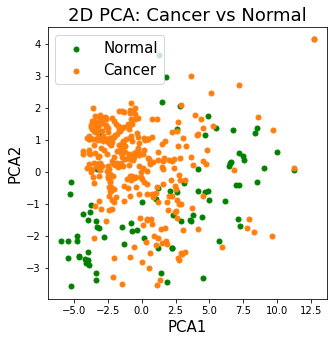

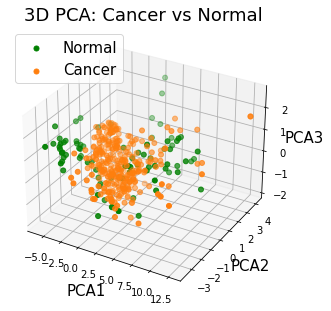

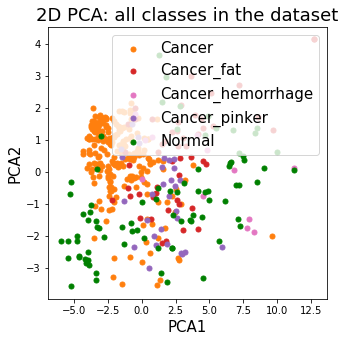

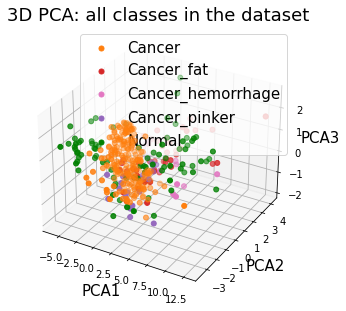

In [21]:
# Plotting parameters
a = 5
figsize = (a,a)
fontLabel = 15
fontTitle = int(fontLabel*1.25)
# All scatter plot color options: https://matplotlib.org/3.1.0/gallery/color/named_colors.html

# 2D PCA: Cancer vs Normal
labels = [0,1]
colours = ['g','tab:orange']
plt.figure(figsize=figsize)
for label, colour in zip(labels,colours):
    plt.scatter(data_pca_df[data_pca_df['Label (numeric)'] == label]['PCA1'],data_pca_df[data_pca_df['Label (numeric)'] == label]['PCA2'],c = colour,s=25)
    # plt.scatter(data_pca_df[data_pca_df['Label (numeric)'] == 1]['PCA1'],data_pca_df[data_pca_df['Label (numeric)'] == 1]['PCA2'],c = colour,s=25)
plt.title('2D PCA: Cancer vs Normal', fontsize=fontTitle)
plt.xlabel('PCA1', fontsize=fontLabel)
plt.ylabel('PCA2', fontsize=fontLabel)
plt.legend(['Normal','Cancer'], fontsize=fontLabel)

# 3D PCA: Cancer vs Normal
labels = [0,1]
colours = ['g','tab:orange']
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111, projection='3d')
for label, colour in zip(labels,colours):
    ax.scatter(data_pca_df[data_pca_df['Label (numeric)'] == label]['PCA1'],data_pca_df[data_pca_df['Label (numeric)'] == label]['PCA2'],data_pca_df[data_pca_df['Label (numeric)'] == label]['PCA3'],c = colour,s=25)
    # plt.scatter(data_pca_df[data_pca_df['Label (numeric)'] == 1]['PCA1'],data_pca_df[data_pca_df['Label (numeric)'] == 1]['PCA2'],c = colour,s=25)
ax.set_title('3D PCA: Cancer vs Normal', fontsize=fontTitle)
ax.set_xlabel('PCA1', fontsize=fontLabel)
ax.set_ylabel('PCA2', fontsize=fontLabel)
ax.set_zlabel('PCA3', fontsize=fontLabel)
ax.legend(['Normal','Cancer'], fontsize=fontLabel)

# 2D PCA: all classes in the dataset
# get the unique labels
labels = np.unique(data_pca_df['Label'])
colours = ['tab:orange','tab:red','tab:pink','tab:purple','g']
plt.figure(figsize=figsize)
for label, colour in zip(labels,colours):
    print('here')
    plt.scatter(data_pca_df[data_pca_df['Label'] == label]['PCA1'],data_pca_df[data_pca_df['Label'] == label]['PCA2'],c=colour,s=25)
plt.title('2D PCA: all classes in the dataset', fontsize=fontTitle)
plt.xlabel('PCA1', fontsize=fontLabel)
plt.ylabel('PCA2', fontsize=fontLabel)
plt.legend(labels, fontsize=fontLabel)

# 3D PCA: all classes in the dataset
# get the unique labels
labels = np.unique(data_pca_df['Label'])
colours = ['tab:orange','tab:red','tab:pink','tab:purple','g']
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111, projection='3d')
for label, colour in zip(labels,colours):
    ax.scatter(data_pca_df[data_pca_df['Label'] == label]['PCA1'],data_pca_df[data_pca_df['Label'] == label]['PCA2'],data_pca_df[data_pca_df['Label'] == label]['PCA3'],c=colour,s=25)
ax.set_title('3D PCA: all classes in the dataset', fontsize=fontTitle)
ax.set_xlabel('PCA1', fontsize=fontLabel)
ax.set_ylabel('PCA2', fontsize=fontLabel)
ax.set_zlabel('PCA3', fontsize=fontLabel)
ax.legend(labels, fontsize=fontLabel)

### PCA: Sample separation

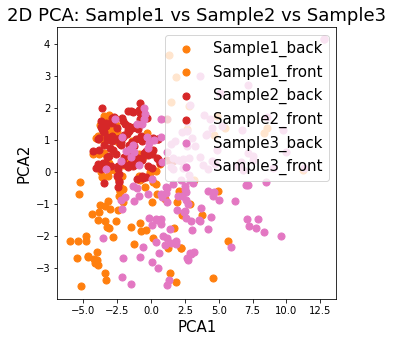

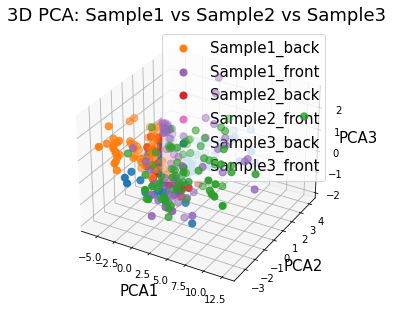

In [22]:
# 2D PCA: Sample1 vs Sample2 vs Sample3
# get the unique labels
labels = np.unique(data_pca_df['SampleID'])
colours = ['tab:orange','tab:orange','tab:red','tab:red','tab:pink','tab:pink']
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
for label, colour in zip(labels,colours):
    ax.scatter(data_pca_df[data_pca_df['SampleID'] == label]['PCA1'],data_pca_df[data_pca_df['SampleID'] == label]['PCA2'],c=colour,s=50)
ax.set_title('2D PCA: Sample1 vs Sample2 vs Sample3', fontsize=fontTitle)
ax.set_xlabel('PCA1', fontsize=fontLabel)
ax.set_ylabel('PCA2', fontsize=fontLabel)
ax.legend(labels, fontsize=fontLabel)

# 3D PCA: Sample1 vs Sample2 vs Sample3
# get the unique labels
labels = np.unique(data_pca_df['SampleID'])
colours = ['tab:orange','tab:purple','tab:red','tab:pink','tab:blue','tab:green']
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111, projection='3d')
for label, colour in zip(labels,colours):
    ax.scatter(data_pca_df[data_pca_df['SampleID'] == label]['PCA1'],data_pca_df[data_pca_df['SampleID'] == label]['PCA2'],data_pca_df[data_pca_df['SampleID'] == label]['PCA3'],c=colour,s=50)
ax.set_title('3D PCA: Sample1 vs Sample2 vs Sample3', fontsize=fontTitle)
ax.set_xlabel('PCA1', fontsize=fontLabel)
ax.set_ylabel('PCA2', fontsize=fontLabel)
ax.set_zlabel('PCA3', fontsize=fontLabel)
ax.legend(labels, fontsize=fontLabel)


(399, 2578, 2)


<Figure size 432x288 with 0 Axes>

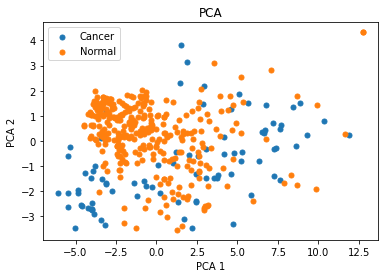

<Figure size 432x288 with 0 Axes>

In [23]:
# Perform PCA on the data to scale it down to 2 dimensions
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
# concatenate the data
data = np.concatenate((data_0_norm,data_1_norm),axis=0)
print(data.shape)

pca.fit(data[:,:,1])
data_0_pca = pca.transform(data_0_norm[:,:,1])
data_1_pca = pca.transform(data_1_norm[:,:,1])

# Plot the PCA data separated by cancer and normal
plot_title = 'PCA'
plt.figure()
plt.scatter(data_0_pca[:,0],data_0_pca[:,1],s=25)
plt.scatter(data_1_pca[:,0],data_1_pca[:,1],s=25)
plt.title(plot_title)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(['Cancer','Normal'])
# save the plot as a vector graphic
plt.savefig('Experiments/PrelimKidney/'+ plot_title + '.svg')

# Plot the PCA data separated by sample number
plot_title = 'All_Data_PCA'
plt.figure()



### LDA fitting

In [25]:
# Proceed with LDA on the data
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Get the data from the dataframe
data = np.array(processedData_df['Data_preprocessed'].tolist())[:,:,1]
# Get the labels from the dataframe
labels = np.array(processedData_df['Label (numeric)'].tolist())

# Create the LDA object
lda = LinearDiscriminantAnalysis(n_components=1)
# Fit the LDA object to the data and labels
lda.fit(data, labels)
# Transform the data
data_lda = lda.transform(data)
print(data_lda.shape)
# Create a dataframe with the LDA data
data_lda_df = pd.DataFrame(data_lda, columns=['LDA1'])
# Add the LDA data to the dataframe
data_lda_df = pd.concat([processedData_df, data_lda_df], axis=1)
data_lda_df

(399, 1)


,PatientID,SampleID,Label (numeric),Label,Data,Data_preprocessed,LDA1
0,PatientA,Sample1_back,1,Cancer,"[[360.14014912872346, 0.0055262738350994245], ...","[[420.90898285766394, 0.4245201373347302], [42...",-1.490441
1,PatientA,Sample1_back,1,Cancer,"[[360.14014912872346, 0.0021762760675127974], ...","[[420.90898285766394, 0.4226748589753229], [42...",1.019156
2,PatientA,Sample1_back,1,Cancer,"[[360.14014912872346, 0.004287867652463011], [...","[[420.90898285766394, 0.4132357321489093], [42...",-0.362514
3,PatientA,Sample1_back,1,Cancer,"[[360.14014912872346, 0.003312623581628423], [...","[[420.90898285766394, 0.39747519008814647], [4...",1.562011
4,PatientA,Sample1_back,1,Cancer,"[[360.14014912872346, 0.008101678916785034], [...","[[420.90898285766394, 0.45333130029464574], [4...",-0.829275
...,...,...,...,...,...,...,...
394,PatientA,Sample3_front,0,Normal,"[[360.14014912872346, 0.0016519205206512518], ...","[[420.90898285766394, 0.20735284105459728], [4...",-5.510709
395,PatientA,Sample3_front,0,Normal,"[[360.14014912872346, 0.0020590573105211396], ...","[[420.90898285766394, 0.172698546349883], [421...",-4.974326
396,PatientA,Sample3_front,0,Normal,"[[360.14014912872346, 0.002182790787293707], [...","[[420.90898285766394, 0.1662806796306154], [42...",-5.082125
397,PatientA,Sample3_front,0,Normal,"[[360.14014912872346, 0.0011315139349880599], ...","[[420.90898285766394, 0.23730179021704045], [4...",-4.732208


### LDA: Class separation

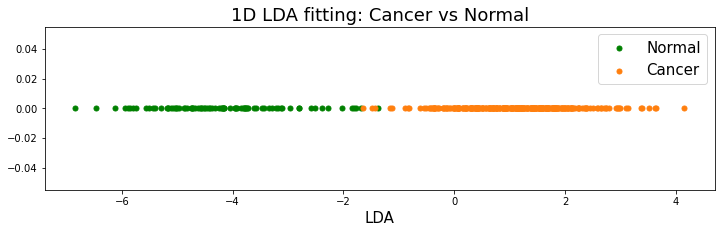

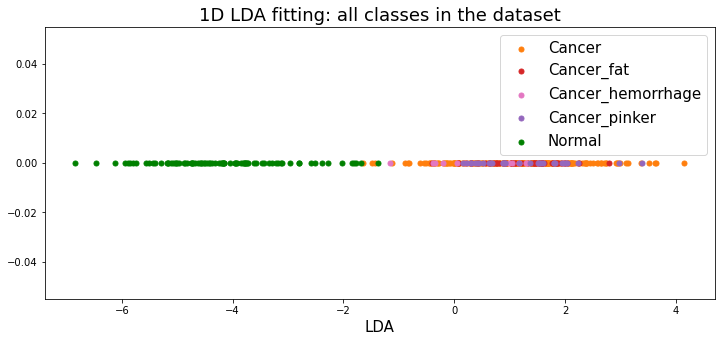

In [26]:
# 1D LDA: Cancer vs Normal
labels = [0,1]
colours = ['g','tab:orange']
plt.figure(figsize=[12,3])
for label, colour in zip(labels,colours):
    plt.scatter(data_lda_df[data_lda_df['Label (numeric)'] == label]['LDA1'],y = np.zeros_like(data_lda_df[data_lda_df['Label (numeric)'] == label]['LDA1']) + 0.,c = colour,s=25)
plt.title('1D LDA fitting: Cancer vs Normal', fontsize=fontTitle)
plt.xlabel('LDA', fontsize=fontLabel)
plt.legend(['Normal','Cancer'], fontsize=fontLabel)

# 1D LDA: All classes in the dataset
# get the unique labels
labels = np.unique(data_lda_df['Label'])
colours = ['tab:orange','tab:red','tab:pink','tab:purple','g']
plt.figure(figsize=[12,5])
for label, colour in zip(labels,colours):
    plt.scatter(data_lda_df[data_lda_df['Label'] == label]['LDA1'],y = np.zeros_like(data_lda_df[data_lda_df['Label'] == label]['LDA1']) + 0.,c = colour,s=25)
plt.title('1D LDA fitting: all classes in the dataset', fontsize=fontTitle)
plt.xlabel('LDA', fontsize=fontLabel)
plt.legend(labels, fontsize=fontLabel)

### LDA: Sample separation

['Sample1_front' 'Sample2_back' 'Sample2_front' 'Sample3_back'
 'Sample3_front']
['tab:orange', 'tab:red', 'tab:red', 'tab:pink', 'tab:pink']
Sample1_front tab:orange
Sample2_back tab:red
Sample2_front tab:red
Sample3_back tab:pink
Sample3_front tab:pink


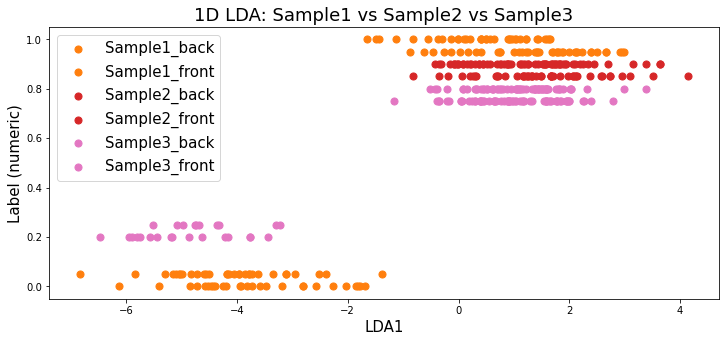

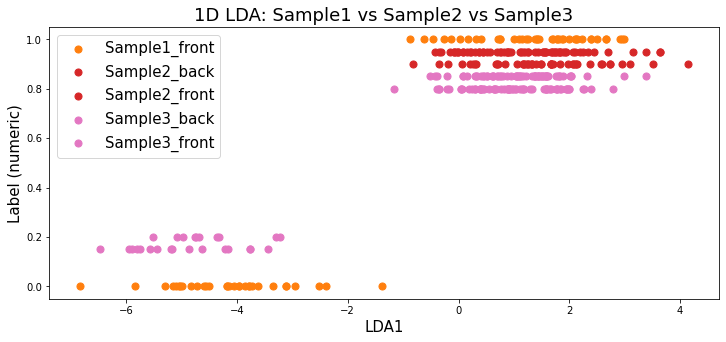

In [33]:
# 1D LDA: Sample1 vs Sample2 vs Sample3
SeparationIdx = 0
SeparationIncrement = 0.05
labels = np.unique(data_lda_df['SampleID'])
colours = ['tab:orange','tab:orange','tab:red','tab:red','tab:pink','tab:pink']
fig = plt.figure(figsize=[12,5])
ax = fig.add_subplot(111)
for label, colour in zip(labels,colours):
    x = data_lda_df[data_lda_df['SampleID'] == label]['LDA1']
    y = data_lda_df[data_lda_df['SampleID'] == label]['Label (numeric)']
    # Spread out the data for better visibility
    y = np.where(y==0,y+SeparationIdx,y-SeparationIdx)
    ax.scatter(x,y,c=colour,s=50)
    SeparationIdx = SeparationIdx + SeparationIncrement
ax.set_title('1D LDA: Sample1 vs Sample2 vs Sample3', fontsize=fontTitle)
ax.set_xlabel('LDA1', fontsize=fontLabel)
ax.set_ylabel('Label (numeric)', fontsize=fontLabel)
ax.legend(labels, fontsize=fontLabel)

# 1D LDA: Sample1 vs Sample2 vs Sample3
SeparationIdx = 0
labels = np.unique(data_lda_df['SampleID'])[1:] # remove the first label
print(labels)
colours = ['tab:orange','tab:orange','tab:red','tab:red','tab:pink','tab:pink'][1:] # remove the first label
print(colours)
fig = plt.figure(figsize=[12,5])
ax = fig.add_subplot(111)
for label, colour in zip(labels,colours):
    print(label, colour)
    x = data_lda_df[data_lda_df['SampleID'] == label]['LDA1']
    y = data_lda_df[data_lda_df['SampleID'] == label]['Label (numeric)']
    # if y is 0 add 0.1 else subtract 0.1
    y = np.where(y==0,y+SeparationIdx,y-SeparationIdx)
    ax.scatter(x,y,c=colour,s=50)
    SeparationIdx = SeparationIdx + SeparationIncrement
ax.set_title('1D LDA: Sample1 vs Sample2 vs Sample3', fontsize=fontTitle)
ax.set_xlabel('LDA1', fontsize=fontLabel)
ax.set_ylabel('Label (numeric)', fontsize=fontLabel)
ax.legend(labels, fontsize=fontLabel)

### t-SNE